Train assignee prediction model (Aurora) with:
- Whitelisted assignees only
- Balanced dataset per assignee (downsample + oversample)
- Debug outputs for each step

In [10]:
import os
import warnings
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    top_k_accuracy_score,
)
from sklearn.utils import resample

from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings("ignore")

In [11]:
# -----------------------------
# 1) CONFIG
# -----------------------------
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "assignee_model_v3_aurora.joblib")
LABEL_ENCODER_PATH = os.path.join(MODEL_DIR, "assignee_label_encoder_aurora.joblib")

PROJECTS = {
    "Aurora": {
        "issues":  r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues 554.csv",
        "summary": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Issues summery 568.csv",
        "sprints": r"PM_Kaggle_dataset\AgileScrumSprintVelocityDataSet\Agile Scrum Dataset\Finalized Datasets for Aurora Project\Aurora Sprints 41.csv",
    },
}

# Only these assignees will be used (whitelist)
ALLOWED_ASSIGNEES = [
    "Maxim Khutornenko",
    "Bill Farner",
    "Kevin Sweeney",
    "Mark Chu-Carroll",
    "Zameer Manji",
    "Joshua Cohen",
    "Brian Wickman",
    "David McLaughlin",
]

# If you want to ensure minimum samples per assignee after balancing
MIN_SAMPLES_PER_CLASS = 2

In [12]:
# -----------------------------
# 2) HELPERS
# -----------------------------
def _lower_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

def safe_div(a, b, default=0.0):
    try:
        return float(a) / float(b) if b and not pd.isna(b) else default
    except Exception:
        return default

def _parse_date(x):
    try:
        return pd.to_datetime(x, errors="coerce")
    except Exception:
        return np.nan

def extract_label(summary, desc=""):
    """Simple keyword-based label extraction."""
    text = f"{summary} {desc}".lower()
    if any(k in text for k in ["ui", "react", "frontend", "css", "html", "layout", "component"]):
        return "frontend"
    if any(k in text for k in ["api", "backend", "server", "database", "controller", "prisma", "nest"]):
        return "backend"
    if any(k in text for k in ["deploy", "docker", "pipeline", "ci", "cd", "aws", "devops"]):
        return "devops"
    if any(k in text for k in ["test", "qa", "bug", "error", "issue"]):
        return "testing"
    return "general"

def debug_print_assignee_distribution(df: pd.DataFrame, title: str):
    print("\n" + "="*60)
    print(f"{title}")
    print("="*60)
    if "assignee" not in df.columns:
        print("Column 'assignee' not found in dataframe.")
        return
    counts = df["assignee"].value_counts()
    print(counts)
    print(f"\nTotal rows      : {df.shape[0]}")
    print(f"Unique assignees: {counts.shape[0]}")
    print("="*60 + "\n")

In [13]:
# -----------------------------
# 3) LOAD & MERGE ALL PROJECTS
# -----------------------------
def load_and_merge_projects():
    combined = []

    print(">>> Loading and merging project CSVs...")
    for pname, p in PROJECTS.items():
        try:
            iss = _lower_cols(pd.read_csv(p["issues"], on_bad_lines="skip", engine="python"))
            summ = _lower_cols(pd.read_csv(p["summary"], on_bad_lines="skip", engine="python"))
            spr  = _lower_cols(pd.read_csv(p["sprints"], on_bad_lines="skip", engine="python"))
        except Exception as e:
            print(f"⚠️ {pname}: error loading -> {e}")
            continue

        print(f"\n--- Project: {pname} ---")
        print("Issues shape :", iss.shape)
        print("Summary shape:", summ.shape)
        print("Sprints shape:", spr.shape)

        # Normalize column names
        rename_map = {
            "priority": "priorityid",
            "priority_id": "priorityid",
            "storypoints": "storypoint",
        }
        iss.rename(columns={k: v for k, v in rename_map.items() if k in iss.columns}, inplace=True)

        # Sprint derived fields
        for c in ["sprintstartdate", "sprintenddate"]:
            if c in spr.columns:
                spr[c] = spr[c].apply(_parse_date)

        if "sprintlength" not in spr.columns:
            spr["sprintlength"] = (spr["sprintenddate"] - spr["sprintstartdate"]).dt.days.clip(lower=1)

        spr["velocity_sp_per_day"] = spr.apply(
            lambda r: safe_div(r.get("completedissuesestimatesum", 0), r.get("sprintlength", 0)),
            axis=1,
        )

        # Merge summary + sprint
        join = summ.merge(spr, on="sprintid", how="left", suffixes=("", "_spr"))

        # Merge issues (detailed info)
        if "issuekey" in join.columns and "key" in iss.columns:
            join = join.merge(
                iss[[
                    "key",
                    "storypoint",
                    "issuetype",
                    "status",
                    "assignee",
                    "priorityid",
                    "summary",
                    "description",
                ]],
                left_on="issuekey",
                right_on="key",
                how="left",
            )

        # Extract labels if not present
        if "labels" not in join.columns:
            join["labels"] = join.apply(
                lambda r: extract_label(r.get("summary", ""), r.get("description", "")),
                axis=1,
            )

        # Clean assignee columns
        if "assignee_x" in join.columns and "assignee_y" in join.columns:
            join["assignee"] = join["assignee_y"].fillna(join["assignee_x"])
        elif "assignee_x" in join.columns:
            join.rename(columns={"assignee_x": "assignee"}, inplace=True)
        elif "assignee_y" in join.columns:
            join.rename(columns={"assignee_y": "assignee"}, inplace=True)

        # Clean assignee / status / priorityid columns
        for col in ["assignee", "status", "priorityid"]:
            cx, cy = f"{col}_x", f"{col}_y"
            if cx in join.columns and cy in join.columns:
                join[col] = join[cy].fillna(join[cx])
            elif cx in join.columns:
                join.rename(columns={cx: col}, inplace=True)
            elif cy in join.columns:
                join.rename(columns={cy: col}, inplace=True)


        join["project"] = pname
        combined.append(join)

    if not combined:
        raise RuntimeError("No project data was loaded successfully.")
    df = pd.concat(combined, ignore_index=True)
    print("\n✅ Loaded combined dataframe. Shape:", df.shape)
    return df

In [14]:
# -----------------------------
# 4) BALANCE DATASET
# -----------------------------
def balance_by_assignee(df: pd.DataFrame) -> pd.DataFrame:
    """
    Make class distribution roughly equal per assignee by:
    - downsampling classes with too many samples
    - oversampling classes with too few samples

    Target per class = median of original distribution.
    """
    debug_print_assignee_distribution(df, "Before balancing per assignee")

    counts = df["assignee"].value_counts()
    target_per_class = int(counts.median())

    print(f">>> Balancing per assignee with target_per_class = {target_per_class}")
    balanced_parts = []

    for assignee in counts.index:
        subset = df[df["assignee"] == assignee]

        if len(subset) > target_per_class:
            # Downsample majority
            subset_bal = resample(
                subset,
                replace=False,             # no replacement
                n_samples=target_per_class,
                random_state=42,
            )
            action = "downsampled"
        elif len(subset) < target_per_class:
            # Oversample minority
            subset_bal = resample(
                subset,
                replace=True,
                n_samples=target_per_class,
                random_state=42,
            )
            action = "oversampled"
        else:
            subset_bal = subset
            action = "kept"

        print(f"  - {assignee:25s}: {len(subset):4d} -> {len(subset_bal):4d} ({action})")
        balanced_parts.append(subset_bal)

    df_bal = pd.concat(balanced_parts, ignore_index=True)
    debug_print_assignee_distribution(df_bal, "After balancing per assignee")

    return df_bal

In [15]:
# -----------------------------
# 5) MAIN TRAINING LOGIC
# -----------------------------
def main():
    # Step 1: Load & merge
    df = load_and_merge_projects()

    # Step 2: Keep only rows with assignee
    mask_assignee = df["assignee"].notna() & (df["assignee"].astype(str).str.strip() != "")
    df = df[mask_assignee].copy()
    debug_print_assignee_distribution(df, "After dropping rows with empty assignee")

    # Step 3: Filter using whitelist
    print(">>> Applying whitelist for assignees...")
    df = df[df["assignee"].isin(ALLOWED_ASSIGNEES)].copy()
    debug_print_assignee_distribution(df, "After whitelist filter")

    # Safety check
    remaining = set(df["assignee"].unique())
    not_allowed = remaining.difference(ALLOWED_ASSIGNEES)
    if not_allowed:
        print("⚠️ WARNING: Found unexpected assignees after whitelist:", not_allowed)

    # Step 4: Ensure feature columns exist
    num_feats = [
        "storypoint",
        "priorityid",
        "velocity_sp_per_day",
        "sprintlength",
        "completedissuesestimatesum",
        "noofdevelopers",
    ]
    cat_feats = ["issuetype", "status", "project", "labels"]

    for nf in num_feats:
        if nf not in df.columns:
            print(f"⚠️ Numeric feature '{nf}' not found. Filling with 0.")
            df[nf] = 0

    for cf in cat_feats:
        if cf not in df.columns:
            print(f"⚠️ Categorical feature '{cf}' not found. Filling with 'Unknown'.")
            df[cf] = "Unknown"

    # Step 5: Balance dataset by assignee
    df_bal = balance_by_assignee(df)

    # Step 6: Build X, y
    X = df_bal[num_feats + cat_feats]
    y = df_bal["assignee"].astype(str)

    print(">>> Final dataset for training")
    print("X shape:", X.shape)
    print("y length:", len(y))
    print("Unique assignees in y:", y.nunique())

    # Step 7: Filter minimal samples per class (safety)
    counts_bal = y.value_counts()
    valid_assignees = counts_bal[counts_bal >= MIN_SAMPLES_PER_CLASS].index
    mask_valid = y.isin(valid_assignees)
    X = X[mask_valid]
    y = y[mask_valid]

    print("\n>>> After enforcing MIN_SAMPLES_PER_CLASS")
    print("X shape:", X.shape)
    print("y length:", len(y))
    print("Assignee counts:\n", y.value_counts())

    # Step 8: Encode labels
    lbl = LabelEncoder()
    y_encoded = lbl.fit_transform(y)

    joblib.dump(lbl, LABEL_ENCODER_PATH)
    print(f"\n✅ LabelEncoder saved to {LABEL_ENCODER_PATH}")
    print("Label mapping (class_index -> assignee):")
    for idx, name in enumerate(lbl.classes_):
        print(f"  {idx}: {name}")

    # Step 9: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded,
    )

    print("\n>>> Train/test split:")
    print("X_train:", X_train.shape, "| y_train:", y_train.shape)
    print("X_test :", X_test.shape,  "| y_test :", y_test.shape)

    # Step 10: Build pipeline
    pipe = Pipeline([
        ("prep", ColumnTransformer([
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False)),
            ]), num_feats),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ]), cat_feats),
        ])),
        ("clf", XGBClassifier(
            n_estimators=400,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="mlogloss",
            random_state=42,
            n_jobs=-1,
        )),
    ])

    print("\n>>> Training XGBoost model...")
    pipe.fit(X_train, y_train)
    print("✅ Training complete.")

    # Step 11: Evaluation
    print("\n>>> Evaluating model...")
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)

    top1 = accuracy_score(y_test, y_pred)
    top3 = top_k_accuracy_score(
        y_test,
        y_proba,
        k=3,
        labels=pipe.named_steps["clf"].classes_,
    )
    top5 = top_k_accuracy_score(
        y_test,
        y_proba,
        k=5,
        labels=pipe.named_steps["clf"].classes_,
    )

    print(f"\nTop-1 Accuracy: {top1:.3f}")
    print(f"Top-3 Accuracy: {top3:.3f}")
    print(f"Top-5 Accuracy: {top5:.3f}")

    print("\nClassification Report (encoded labels):\n")
    print(classification_report(y_test, y_pred))

    # Optionally map encoded y to string labels for inspection
    y_true_labels = lbl.inverse_transform(y_test)
    y_pred_labels = lbl.inverse_transform(y_pred)

    print("\nSample predictions (first 10):")
    for i in range(min(10, len(y_true_labels))):
        print(f"  True: {y_true_labels[i]:25s} | Pred: {y_pred_labels[i]:25s}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Confusion Matrix – Assignee Predictor (Aurora, balanced)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Step 12: Save model
    joblib.dump(pipe, MODEL_PATH)
    print(f"\n✅ Model saved to {MODEL_PATH}")

In [16]:
# -----------------------------
# 6) INFERENCE HELPER (OPTIONAL)
# -----------------------------
def load_model_and_predict(dummy_items, top_k=5):
    """
    Example inference function with debug prints.
    """
    # Load model & label encoder
    pipe = joblib.load(MODEL_PATH)
    lbl = joblib.load(LABEL_ENCODER_PATH)

    num_feats = [
        "storypoint",
        "priorityid",
        "velocity_sp_per_day",
        "sprintlength",
        "completedissuesestimatesum",
        "noofdevelopers",
    ]
    cat_feats = ["issuetype", "status", "project", "labels"]

    results = []
    for it in dummy_items:
        # Init with defaults
        row = {**{k: 0 for k in num_feats}, **{k: "Unknown" for k in cat_feats}}
        row.update(it)

        if "labels" not in row or not row["labels"]:
            row["labels"] = extract_label(row.get("summary", ""), row.get("description", ""))

        df_one = pd.DataFrame([row])
        proba = pipe.predict_proba(df_one[num_feats + cat_feats])[0]

        classes_idx = np.arange(len(proba))
        classes_names = lbl.inverse_transform(classes_idx)
        top_idx = np.argsort(proba)[::-1][:top_k]

        top_preds = [
            {"assignee": classes_names[i], "probability": float(proba[i])}
            for i in top_idx
        ]
        results.append({"input_summary": row.get("summary", ""), "top_k_recommendations": top_preds})

    print("\n>>> Inference debug output:")
    for res in results:
        print(f"\nSummary: {res['input_summary']}")
        for rank, rec in enumerate(res["top_k_recommendations"], 1):
            print(f"  {rank}. {rec['assignee']} ({rec['probability']*100:.2f}%)")

    return results


>>> Loading and merging project CSVs...

--- Project: Aurora ---
Issues shape : (554, 22)
Summary shape: (568, 10)
Sprints shape: (40, 22)

✅ Loaded combined dataframe. Shape: (910, 45)

After dropping rows with empty assignee
assignee
Maxim Khutornenko            263
Bill Farner                  160
Kevin Sweeney                114
Mark Chu-Carroll              81
Joshua Cohen                  68
Zameer Manji                  57
Brian Wickman                 54
David McLaughlin              27
Joe Smith                     12
Suman Karumuri                 6
Santhosh Kumar Shanmugham      4
wfarner                        3
Mehrdad Nurolahzade            3
zmanji                         2
Kai Huang                      2
Dominic Hamon                  1
Stephan Erb                    1
maximk                         1
Benjamin Mahler                1
yasumoto                       1
Name: count, dtype: int64

Total rows      : 861
Unique assignees: 20

>>> Applying whitelist for assign

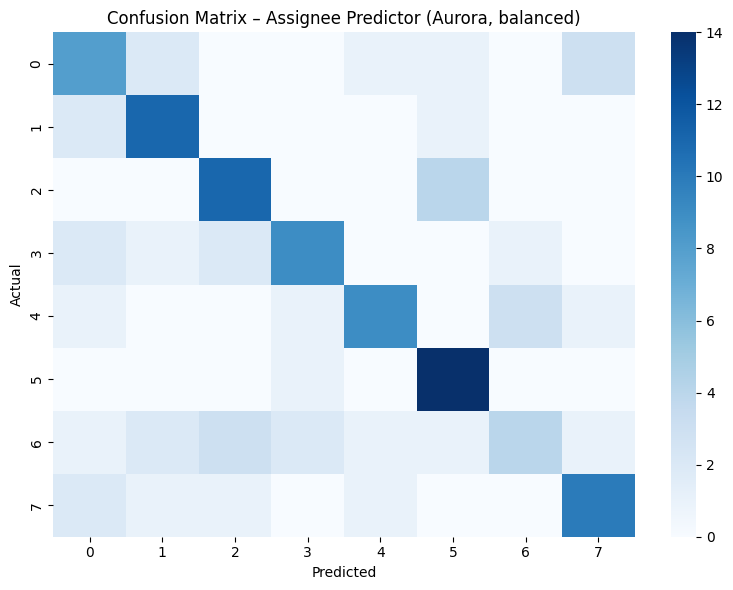


✅ Model saved to models\assignee_model_v3_aurora.joblib

>>> Inference debug output:

Summary: Create responsive UI for login
  1. Kevin Sweeney (95.73%)
  2. Bill Farner (2.34%)
  3. Joshua Cohen (0.50%)
  4. David McLaughlin (0.49%)
  5. Brian Wickman (0.43%)

Summary: Fix backend API error in payment service
  1. Zameer Manji (89.86%)
  2. Maxim Khutornenko (8.52%)
  3. Bill Farner (1.02%)
  4. Kevin Sweeney (0.34%)
  5. Brian Wickman (0.12%)


In [17]:
if __name__ == "__main__":
    main()

    # Optional: quick test after training
    dummy_items = [
        {
            "issuetype": "Story",
            "status": "To Do",
            "storypoint": 5,
            "priorityid": 3,
            "sprintlength": 14,
            "noofdevelopers": 6,
            "project": "Aurora",
            "summary": "Create responsive UI for login",
            "labels": "frontend",
        },
        {
            "issuetype": "Bug",
            "status": "In Progress",
            "storypoint": 2,
            "priorityid": 1,
            "sprintlength": 10,
            "noofdevelopers": 4,
            "project": "Aurora",
            "summary": "Fix backend API error in payment service",
            "labels": "backend",
        },
    ]
    load_model_and_predict(dummy_items, top_k=5)